In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input,InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.optimizers import RMSprop,Adam

In [3]:
#2019 data
'''import cv2
import glob
from tqdm import tqdm
files= glob.glob("../input/aptos2019-blindness-detection/train_images/*.png")
for i in tqdm(range(len(files))):
    img = cv2.imread(files[i])
    green=img[:,:,1]
    clache= cv2.createCLAHE(clipLimit=3.0)
    clache_img= clache.apply(green) 
    median_img= cv2.medianBlur(clache_img,5)
    

    resize_img=cv2.resize(median_img,(256,256))
    

    #canny_img= cv2.Canny(resize_img,75,200)

    
    cv2.imwrite("./"+os.path.basename(files[i]), resize_img)'''

'import cv2\nimport glob\nfrom tqdm import tqdm\nfiles= glob.glob("../input/aptos2019-blindness-detection/train_images/*.png")\nfor i in tqdm(range(len(files))):\n    img = cv2.imread(files[i])\n    green=img[:,:,1]\n    clache= cv2.createCLAHE(clipLimit=3.0)\n    clache_img= clache.apply(green) \n    median_img= cv2.medianBlur(clache_img,5)\n    \n\n    resize_img=cv2.resize(median_img,(256,256))\n    \n\n    #canny_img= cv2.Canny(resize_img,75,200)\n\n    \n    cv2.imwrite("./"+os.path.basename(files[i]), resize_img)'

In [4]:
base_image_dir= os.path.join("..","input", "aptos2019-blindness-detection")
print(base_image_dir)
retina_df2019 = pd.read_csv(os.path.join(base_image_dir, "train.csv"))
#retina_df["PatientId"]= retina_df["id_code"].map(lambda x: x.split("_")[0])
retina_df2019['path'] = retina_df2019['id_code'].map(lambda x: os.path.join("../input/aptos2019-blindness-detection/train_images",'{}.png'.format(x)))
retina_df2019["exists"]= retina_df2019["path"].map(os.path.exists)
print(retina_df2019["exists"].sum(),"found of",retina_df2019.shape[0], "total")
retina_df2019.dropna(inplace= True)
retina_df2019= retina_df2019[retina_df2019["exists"]]
retina_df=retina_df2019

../input/aptos2019-blindness-detection
3662 found of 3662 total


In [5]:
from tqdm import tqdm
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in tqdm(data_frame.iterrows()):  
        Y[index,entry[labelcol]] = 1
        img = cv2.imread(entry[filenamecol])
        green=img[:,:,1]
        clache= cv2.createCLAHE(clipLimit=3.0)
        clache_img= clache.apply(green) 
        median_img= cv2.medianBlur(clache_img,5)


        resize_img=cv2.resize(median_img,(256,256))
        layer=cv2.merge((resize_img,resize_img,resize_img))
        X[index,:] =layer
        X[index,:] = X[index,:] /255.0
    return X,Y

In [6]:
from sklearn.model_selection import train_test_split
train_df,val_df= train_test_split(retina_df,
                                    random_state = 42,
                                    shuffle= True,
                                    test_size=0.2)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [7]:
batch_size = 32
img_size = 256
X_train,Y_train = load_raw_images_df(train_df,"path","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"path","diagnosis",img_size,5)


2929it [06:58,  7.00it/s]
733it [01:46,  6.91it/s]


In [8]:
path= "../input/d/madmaxliu/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model=InceptionV3(weights=path,input_shape=(256,256,3),include_top=False)
for layer in pre_trained_model.layers:
    layer.trainable=False
last_layer=pre_trained_model.get_layer("mixed7")
last_output= last_layer.output
x= layers.Flatten()(last_output)
x=layers.Dense(1024,activation="relu")(x)
x=layers.Dropout(0.2)(x)
x= layers.Dense(5,activation="softmax")(x)
model= Model(pre_trained_model.input,x)

In [9]:
model.compile(optimizer=Adam(lr=0.00005),loss = "categorical_crossentropy" ,metrics = ["accuracy"])

In [10]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,  
            fill_mode='constant', 
            cval=0.,  
            horizontal_flip=True,  
            vertical_flip=True)



In [11]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
mc= ModelCheckpoint(filepath= "./best_model.h5",
                    monitor="accuracy",
                    verbose=1,
                    save_best_only=True)
es=EarlyStopping(monitor="accuracy",
                 min_delta=0.01,
                 patience=8,
                 verbose=1)
cb=[mc,es]

In [12]:
EPOCHS = 10
history=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), 
                        validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]/32,
                            callbacks=cb, epochs=EPOCHS)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
91/91 [==============================] - 311s 3s/step - loss: 1.1176 - accuracy: 0.6386 - val_loss: 0.7077 - val_accuracy: 0.7353

Epoch 00001: accuracy improved from -inf to 0.68283, saving model to ./best_model.h5
Epoch 2/10
91/91 [==============================] - 306s 3s/step - loss: 0.6876 - accuracy: 0.7304 - val_loss: 0.6845 - val_accuracy: 0.7435

Epoch 00002: accuracy improved from 0.68283 to 0.73745, saving model to ./best_model.h5
Epoch 3/10
91/91 [==============================] - 303s 3s/step - loss: 0.6364 - accuracy: 0.7368 - val_loss: 0.6448 - val_accuracy: 0.7599

Epoch 00003: accuracy improved from 0.73745 to 0.74326, saving model to ./best_model.h5
Epoch 4/10
91/91 [==============================] - 312s 3s/step - loss: 0.5921 - accuracy: 0.7675 - val_loss: 0.6004 - val_accuracy: 0.7899

Epoch 00004: accuracy improved from 0.74326 to 0.76511, saving model to ./best_model.h5
Epoch 5/10
91/91 [==============================] - 311s 3s/step - loss: 0.6093 - a

In [13]:
from tensorflow.keras.models import load_model

model= load_model("./best_model.h5")
h= history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

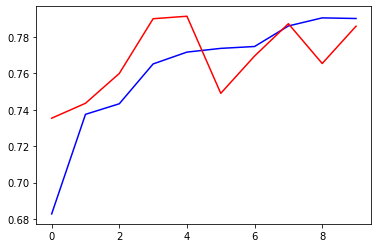

In [14]:
import matplotlib.pyplot as plt
plt.plot(h["accuracy"],c="blue")
plt.plot(h["val_accuracy"],c="red")
plt.show()

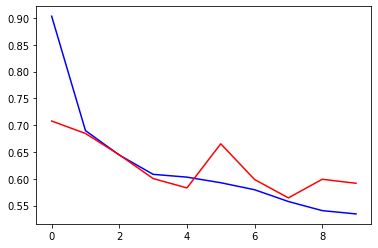

In [15]:
import matplotlib.pyplot as plt
plt.plot(h["loss"],c="blue")
plt.plot(h["val_loss"],c="red")
plt.show()

In [16]:

test_data=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")



In [17]:

test_data['filename'] = test_data['id_code'].map(lambda x: x+".png")

In [18]:
test_gen=ImageDataGenerator(rescale=1./255)
test_generator=test_gen.flow_from_dataframe(

                                dataframe=test_data,
                                directory="../input/aptos2019-blindness-detection/test_images",
                                x_col="filename",
                                y_col=None,
                                
                                target_size=(256,256),
                                color_mode="rgb",
                                batch_size=1,
                                shuffle=False,
                                class_mode=None)

Found 1928 validated image filenames.


In [19]:
predictions=model.predict_generator(test_generator,steps=len(test_generator.filenames))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [20]:
filenames=test_generator.filenames
results=pd.DataFrame(
{"id_code":filenames,
"diagnosis":np.argmax(predictions,axis=1),
})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

In [21]:
output= pd.read_csv("./submission.csv")

In [22]:
output

id_code  diagnosis
0     0005cfc8afb6          0
1     003f0afdcd15          2
2     006efc72b638          2
3     00836aaacf06          2
4     009245722fa4          2
...            ...        ...
1923  ff2fd94448de          0
1924  ff4c945d9b17          2
1925  ff64897ac0d8          2
1926  ffa73465b705          4
1927  ffdc2152d455          0

[1928 rows x 2 columns]